In [1]:
"""
Import necessary libraries to create a generative adversarial network
The code is mainly developed using the PyTorch library
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T

from torchvision import datasets
from torchvision.transforms import transforms
#from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
"""
Network Architectures
The following are the discriminator and generator architectures
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [4]:
"""
Hyperparameter settings
"""
epochs = 300
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

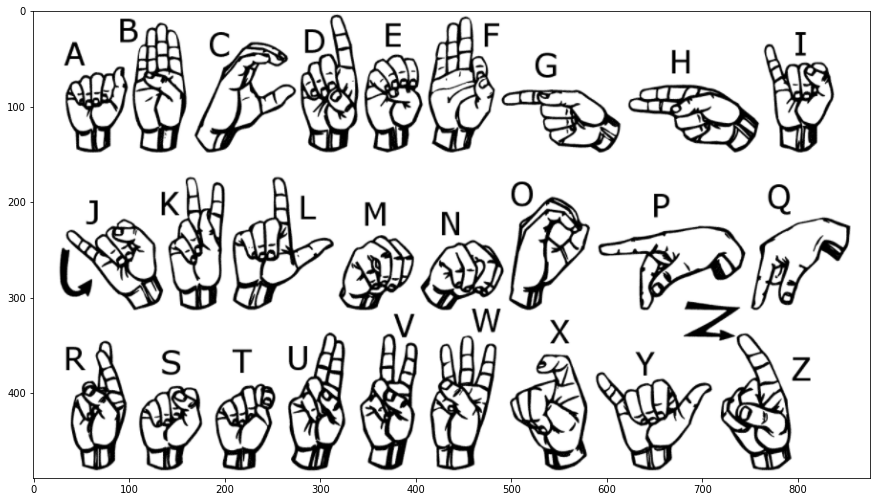

In [5]:
"""
Load data
"""
import cv2

img_path = ["/kaggle/input/sign-language-mnist/american_sign_language.PNG",
            "/kaggle/input/sign-language-mnist/amer_sign3.png",
            "/kaggle/input/sign-language-mnist/amer_sign2.png"]

img = cv2.imread(img_path[0], cv2.IMREAD_COLOR)
plt.figure(figsize=(15,15))
plt.imshow(img)


In [6]:
train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


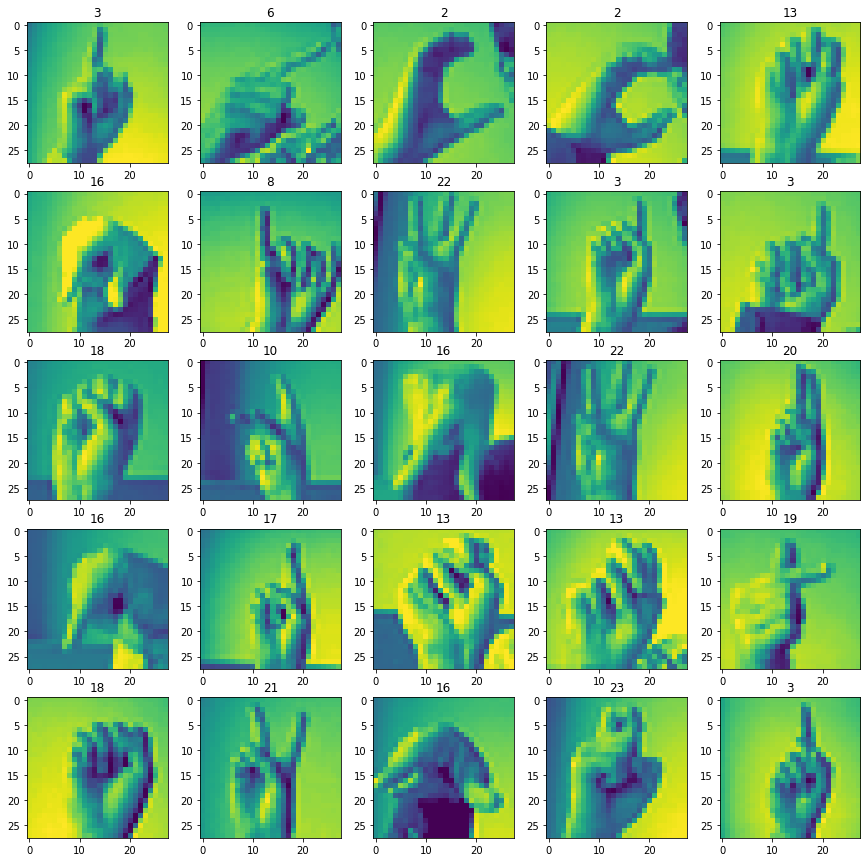

In [7]:
# Examples of images

plt.figure(figsize=(15,15))
for i in range(25):
    img = np.array(train_df.iloc[i, 1:].values).reshape(28,28)

    plt.subplot(5,5, i+1)
    plt.imshow(img)
    plt.title(train_df.iloc[i, 0])

In [8]:
"""
Image transformation and dataloader creation
"""
# Transform
#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.5,), (0.5,))])
# Load data
#train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)



class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, transforms = None):
        
        super().__init__()
        
        self.dataset = dataset
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        
        #Reading image
        item = np.array(self.dataset.iloc[index, 1:].values).reshape(28,28) / 255
        item = torch.from_numpy(item).to(torch.float32)
        item = torch.unsqueeze(item, 0)
        
        label = np.array(self.dataset.iloc[index, 0])
        label = torch.from_numpy(label)
        
        if self.transforms:
            item = self.transforms(item)
            
        return item, label
        
        
    def __len__(self):
        return self.dataset.shape[0]
    
    
train_dataset = MNIST_Dataset(train_df)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
    #sampler = train_random_sampler,
)


In [9]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        #if idx % 100 == 0 or idx == len(train_loader):
    
    print('Epoch {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 40 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0: discriminator_loss 429.000 generator_loss 0.702
Epoch 1: discriminator_loss 429.000 generator_loss 0.707
Epoch 2: discriminator_loss 429.000 generator_loss 0.698
Epoch 3: discriminator_loss 429.000 generator_loss 0.692
Epoch 4: discriminator_loss 429.000 generator_loss 0.682
Epoch 5: discriminator_loss 429.000 generator_loss 0.667
Epoch 6: discriminator_loss 429.000 generator_loss 0.621
Epoch 7: discriminator_loss 429.000 generator_loss 0.726
Epoch 8: discriminator_loss 429.000 generator_loss 0.684
Epoch 9: discriminator_loss 429.000 generator_loss 0.675
Epoch 10: discriminator_loss 429.000 generator_loss 0.689
Epoch 11: discriminator_loss 429.000 generator_loss 0.687
Epoch 12: discriminator_loss 429.000 generator_loss 0.695
Epoch 13: discriminator_loss 429.000 generator_loss 0.709
Epoch 14: discriminator_loss 429.000 generator_loss 0.681
Epoch 15: discriminator_loss 429.000 generator_loss 0.689
Epoch 16: discriminator_loss 429.000 generator_loss 0.690
Epoch 17: discriminator_

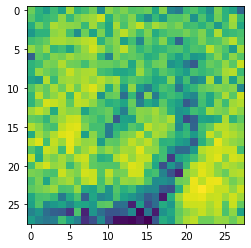

In [10]:
noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
noise = noise.to(device)
fake_inputs = G(noise)
#print(fake_inputs)

plt.imshow(fake_inputs[0].permute(1, 2, 0).detach().cpu())

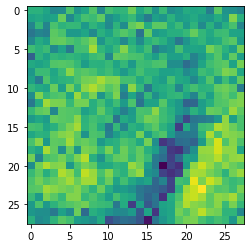

In [11]:
noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
noise = noise.to(device)
fake_inputs = G(noise)
#print(fake_inputs)

plt.imshow(fake_inputs[0].permute(1, 2, 0).detach().cpu())

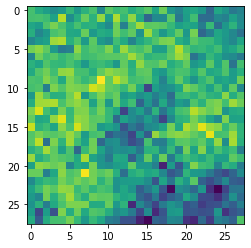

In [12]:
noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
noise = noise.to(device)
fake_inputs = G(noise)
#print(fake_inputs)

plt.imshow(fake_inputs[0].permute(1, 2, 0).detach().cpu())

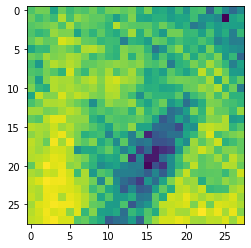

In [13]:
noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
noise = noise.to(device)
fake_inputs = G(noise)
#print(fake_inputs)

plt.imshow(fake_inputs[0].permute(1, 2, 0).detach().cpu())